In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import datetime
current_script_path = os.getcwd()
module_path = os.path.join(current_script_path, '..')
sys.path.append(os.path.abspath(module_path))
from utilities.Obtainer import RotationalFiltersObtainer
import torch
import torch.nn.functional as F
device = 'cpu'
plt.rcParams.update({'font.size': 14})


In [2]:
rotate_resolution = 180 # parameters used to determine the rotation
discretize_paras = {'x_range': (-1, 1), 'y_range':(-1, 1), 'img_resolution':(64, 64)} # parameters used to discrete 2d function to matrix
# gabor_para = {'gaussian_var': 0.485, 'cos_phase': 0, 'cos_freq': 1.5}
gabor_para = {'gaussian_var': 0.485, 'cos_phase': 0, 'cos_freq': 1.5}

In [ ]:
def gabor_generator(xx, yy, cos_freq, cos_phase, gaussian_var, gaussian_aspect_ratio=1, theta=0, coordinate_system='cartesian'):

    # Rotate coordinations
    def rotate_coords(x, y, theta):
        x_rot = x * np.cos(theta) - y * np.sin(theta)
        y_rot = x * np.sin(theta) + y * np.cos(theta)
        return x_rot, y_rot

    # Gabor generator
    def gabor_cartesian(x, y):
        x_rot, y_rot = rotate_coords(x, y, theta)
        return np.exp(-(x_rot**2 + gaussian_aspect_ratio**2 * y_rot**2) / (2 * gaussian_var**2)) * np.cos(2 * np.pi * x_rot * cos_freq + cos_phase)

    return gabor_cartesian(xx, yy)


In [4]:
def gabor_generator(xx, yy, cos_freq, cos_phase, gaussian_var, x_enlarge_factor=1, y_enlarge_factor=1, gaussian_aspect_ratio=1, theta=0, coordinate_system='cartesian'):

    # 旋转坐标
    def rotate_coords(x, y, theta):
        x_rot = x * np.cos(theta) - y * np.sin(theta)
        y_rot = x * np.sin(theta) + y * np.cos(theta)
        return x_rot, y_rot

    # Gabor生成函数
    def gabor_cartesian(x, y):
        x_rot, y_rot = rotate_coords(x, y, theta)
        return np.exp(-((x_rot/x_enlarge_factor)**2 + gaussian_aspect_ratio**2 * (y_rot/y_enlarge_factor)**2) / (2 * gaussian_var**2)) * np.cos(2 * np.pi * x_rot * cos_freq + cos_phase)

    return gabor_cartesian(xx, yy)

# Generate Gabor

Add the perspective of sensitivity: the larger the gain, the stronger the ability to distinguish disturbances.

In [ ]:
def generate_gabor_input(xx, yy, cos_freq=1.5, cos_phase=0, gaussian_var=0.3, x_enlarge_factor=1, y_enlarge_factor=1, gaussian_aspect_ratio=1, theta=np.pi/4, contrast=0.5, if_plot=False):
    gabor = gabor_generator(xx, yy, cos_freq=cos_freq, cos_phase=cos_phase, gaussian_var=gaussian_var, x_enlarge_factor=x_enlarge_factor, y_enlarge_factor=y_enlarge_factor, gaussian_aspect_ratio=gaussian_aspect_ratio, theta=theta)
    # gabor = (gabor-np.min(gabor))/(np.max(gabor)-np.min(gabor))*contrast
    gabor = (gabor)*contrast/np.max(np.abs(gabor))

    if if_plot:
        # Show the result
        plt.imshow(gabor, cmap='gray', extent=(-1, 1, -1, 1),vmin=-np.max(np.abs(gabor)),vmax=np.max(np.abs(gabor)))
        # plt.imshow(gabor, cmap='gray', extent=(-1, 1, -1, 1))
        plt.colorbar()
        plt.show()
    
    return gabor

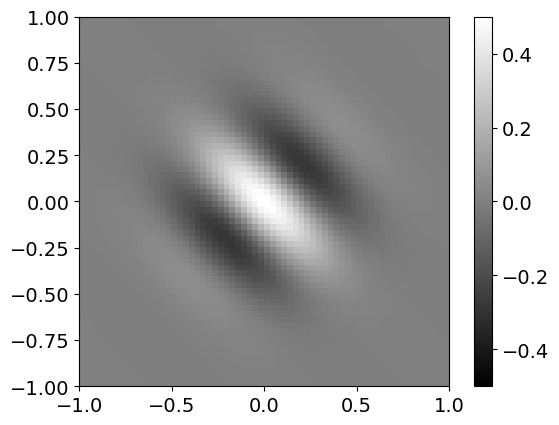

In [96]:
x = np.linspace(-1,1,64)
y = np.linspace(-1,1,64)
xx, yy = np.meshgrid(x, y, indexing='xy')
gabor = generate_gabor_input(xx, yy, cos_freq=1.5, cos_phase=0, gaussian_var=0.3, gaussian_aspect_ratio=1, theta=np.pi/4, contrast=0.5, if_plot=True)

# Calculate the strongest perturbation

In [7]:
def single_gaussian(theta, center, size_ext, periodic=True):
    if periodic: 
        return torch.exp(-(theta - center)**2/(2*size_ext**2))+torch.exp(-(theta - center+180)**2/(2*size_ext**2))+torch.exp(-(theta - center-180)**2/(2*size_ext**2))
    else:
        return torch.exp(-(theta - center)**2/(2*size_ext**2))

def K_XY(N,theta,G_XY,sigma=25):
    K_XY = torch.zeros((N,N),device=device)
    for i in range(N):
        for j in range(N):
            K_XY[i,j]= G_XY*single_gaussian(theta[j],theta[i],sigma)
    return K_XY.double()

class Model:
    def __init__(self, Gabor,g_EE,g_EI,g_IE,K,iterations=10,bias = -100,relu_type='relu'):
        self.Gabor = Gabor
        self.g_EE = g_EE
        self.g_EI = g_EI
        self.g_IE = g_IE
        self.G_EE = g_EE*K.to(device)
        self.G_EI = g_EI*K.to(device)
        self.G_IE = g_IE*K.to(device)
        self.iterations = iterations
        self.bias = bias
        self.relu_type = relu_type

    def forward(self, x, alpha=0.1,I_I = 0):
        # Compute Gabor filter output
        if self.relu_type == 'relu':
            sigma = torch.relu
        else:
            sigma = F.leaky_relu

        Gabor_x = torch.matmul(self.Gabor, x)+self.bias
        self.Gabor_x = Gabor_x

        r_E = sigma(Gabor_x).to(device)
        r_I = sigma(Gabor_x-Gabor_x+I_I).to(device)
        for iters in range(self.iterations):
            r_E_old = r_E
            r_I_old = r_I
            r_E = alpha*sigma(Gabor_x+torch.matmul(self.G_EE,r_E)-torch.matmul(self.G_EI,r_I))+(1-alpha)*r_E_old
            r_I = alpha*sigma(I_I+torch.matmul(self.G_IE,r_E))+(1-alpha)*r_I_old
        r_E = sigma(Gabor_x+torch.matmul(self.G_EE,r_E)-torch.matmul(self.G_EI,r_I))

        self.r_I = r_I

        y = r_E

        return y

    def compute_loss(self, x, y_true):
        # Compute model output
        y = self.forward(x)
        y_true = y_true.double()

        # Compute cross entropy loss
        loss = F.mse_loss(y[[90,0]].unsqueeze(0), y_true[[90,0]].unsqueeze(0))

        return loss 
    
    def compute_gradient(self, x, y_true):
        # Ensure x requires gradient
        x.requires_grad_(True)

        # Zero the gradients of x
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()

        # Compute loss
        loss = self.compute_loss(x, y_true)

        # Compute gradients
        loss.backward()

        # Return gradient of loss with respect to x
        return x.grad

    
    def zero_grad(self):
        if self.Gabor.grad is not None:
            self.Gabor.grad.detach_()
            self.Gabor.grad.zero_()

G = torch.from_numpy(RotationalFiltersObtainer.gabor_filters_matrix())
N = 180
theta = torch.arange(N)/N*180

In [ ]:
def compute_max_pertubation(gabor, ring, if_specific_data=False, plot=False):
    response = ring.forward(torch.from_numpy(gabor.reshape(-1,1)))
    index = torch.nonzero(response.reshape(-1))[:,0]
    print(index.shape)
    kernel = torch.inverse(torch.eye(index.shape[0])-ring.G_EE[index][:,index]+ring.G_EI[index][:,index]@ring.G_IE[index][:,index])
    A = (kernel@(ring.Gabor[index]))

    # Compute the SVD of A
    U, S, Vh = torch.linalg.svd(A)

    # Maximum singular value
    max_singular_value = S[0]

    # Corresponding left and right singular vectors
    left_singular_vector = U[:, 0]
    right_singular_vector = Vh[0, :]

    if if_specific_data:
        print("Matrix A:")
        print(A)

        print("\nMaximum singular value:")
        print(max_singular_value)

        print("\nCorresponding left singular vector (U[:, 0]):")
        print(left_singular_vector)

        print("\nCorresponding right singular vector (Vh[0, :]):")
        print(right_singular_vector)

    # plt.imshow(np.asarray(Vh[0, :]).reshape(64,64))
    if plot:
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
        for i in range(2):
            for j in range(5):
                img = axes[i, j].imshow(np.asarray(Vh[5*i+j, :]).reshape(64,64), cmap='grey')  # Convert image from CHW to HWC
                fig.colorbar(img, ax=axes[i, j])
    return U, S, Vh, response, index, ring

def different_para_fix_ring(ring, variable_ranges, fixed_params=None, save=False, beta=-1):
    # If no fixed parameters are provided, set default values
    if fixed_params is None:
        fixed_params = {
            'cos_freq': 1, 
            'cos_phase': 0, 
            'gaussian_var': 0.3, 
            'gaussian_aspect_ratio': 1, 
            'theta': np.pi/4, 
            'contrast': 0.5
        }
    
    # Get variable names and ranges
    variable_name, variable_values = list(variable_ranges.items())[0]
    
    n_rows = len(variable_values)
    fig, axes = plt.subplots(nrows=n_rows, ncols=7, figsize=(35, 5 * n_rows))

    for i, value in enumerate(variable_values):
        # Update variable parameters
        params = fixed_params.copy()
        params[variable_name] = value  # Update the current loop variable
        
        # Generate Gabor input
        gabor = generate_gabor_input(xx, yy, **params, if_plot=False)
        # print(gabor.shape)

        # gabor = np.asarray(gabor)+np.random.normal(loc=0.0, scale=0.092, size=4096).reshape(64,64)
        
        # Compute the response
        U, S, V, response, index, ring = compute_max_pertubation(gabor, ring, if_specific_data=False, plot=False)

        # Display Gabor image
        img = axes[i, 0].imshow(np.asarray(gabor).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 0])
        axes[i, 0].set_title(f"Gabor({variable_name}={value})")

        axes[i, 1].plot(np.asarray(ring.Gabor_x), label='Gabor_x')
        axes[i, 1].set_title(f"response after gabor")

        # Plot r_E and r_I
        axes[i, 2].plot(np.asarray(response), label='r_E')
        axes[i, 2].plot(np.asarray(ring.r_I), label='r_I')
        axes[i, 2].set_title(f"active range=[{index[0]},{index[-1]}]")

        # response_new = ring.forward(torch.from_numpy(gabor.reshape(-1))+beta*(V[0, :]))
        axes[i, 1].plot(np.asarray(ring.Gabor_x), label='Gabor_delta_x')
        axes[i, 1].legend()
        # axes[i, 2].plot(np.asarray(response_new), label='delta_r_E')
        # axes[i, 2].plot(np.asarray(ring.r_I), label='delta_r_I')
        axes[i, 2].legend()

        # Display V[0] image
        img = axes[i, 3].imshow(np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 3])
        axes[i, 3].set_title(f"Gain = {S[0]}")

        img = axes[i, 4].imshow(np.asarray(V[1, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 4])
        axes[i, 4].set_title(f"Gain = {S[1]}")

        mg = axes[i, 5].imshow(np.asarray(V[2, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 5])
        axes[i, 5].set_title(f"Gain = {S[2]}")

        img = axes[i, 6].imshow(np.asarray(gabor).reshape(64, 64) + beta * np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
        fig.colorbar(img, ax=axes[i, 6])
        axes[i, 6].set_title(f"Gabor({variable_name}={value})")

    plt.tight_layout()

    if save:
        save_path = f"Figure/gEE_{ring.g_EE}_gEI_{ring.g_EI}_gIE_{ring.g_IE}/"
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_name = f"{variable_name}_{current_time}.png"

        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path + file_name)  # Save the image
    plt.show()

    return U, S, V, ring, gabor, response

In [405]:
G = torch.from_numpy(RotationalFiltersObtainer.gabor_filters_matrix())
K = K_XY(N,theta,1,sigma=25)
g_EE = 0.01
g_EI = 0.05
g_IE = 0.04
ring = Model(G,g_EE,g_EI,g_IE,K,bias = -5,iterations=2000)
# g_EE = 0
# g_EI = 0
# g_IE = 0
# ring = Model(G,g_EE,g_EI,g_IE,K,bias = -30,iterations=2000)

torch.Size([79])
torch.Size([89])


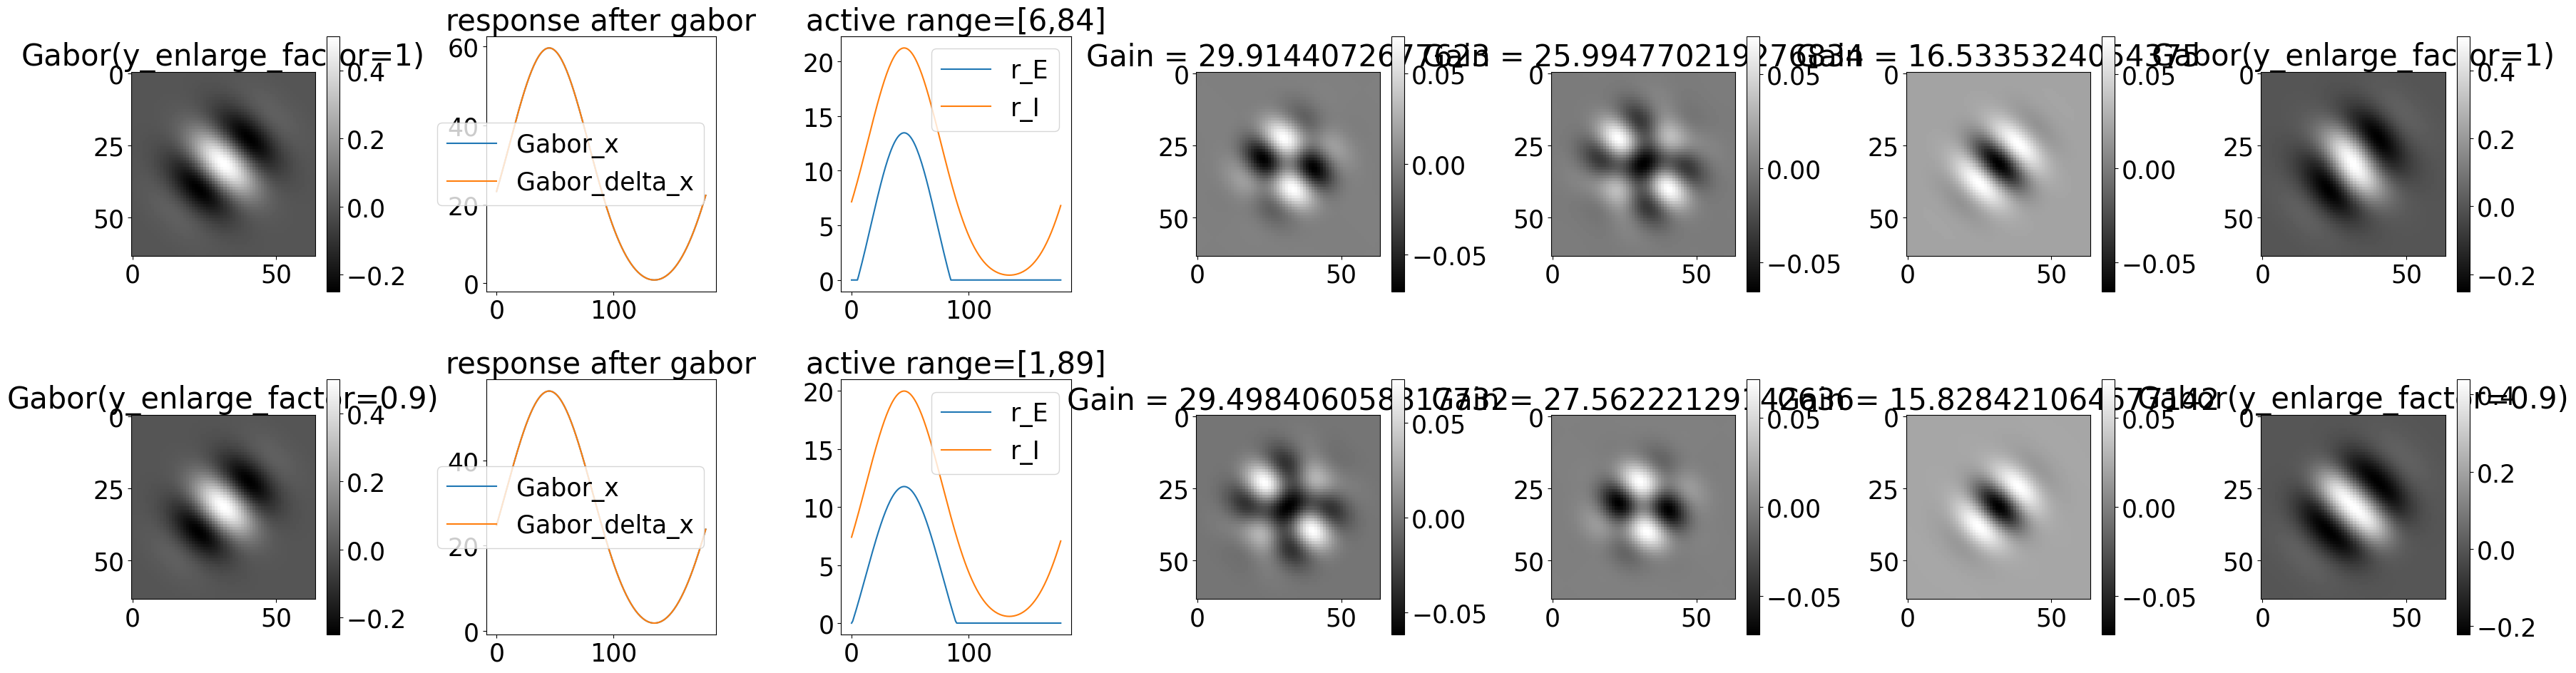

In [406]:
# variable_ranges = {'cos_freq': [0,0.75,1,1.5,2,2.25,3,3.5,4]}
y_en = np.linspace(0.9,4,20)[0]
variable_ranges = {'y_enlarge_factor':[1,y_en]}
# variable_ranges = {'x_enlarge_factor':[0.5,0.75,1,1.25,1.5,2]}
# variable_ranges = {'theta':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}
# variable_ranges = {'cos_phase':[0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]}

# cont = np.linspace(0.5,0.753,20)[-1]
# variable_ranges = {'contrast':[0.5,cont]}

# variable_ranges_list = [
#     {'cos_freq': [0,0.75,1,1.5,2,2.5,3]},
#     {'y_enlarge_factor': [0.5,0.75,1,1.25,1.5,2]},
#     {'x_enlarge_factor': [0.5,0.75,1,1.25,1.5,2]},
#     {'theta': [0,torch.pi/6,torch.pi/4,torch.pi/3,torch.pi/2]},
#     {'cos_phase': [0,torch.pi/8,torch.pi/6,torch.pi/4,torch.pi/3]},
#     {'contrast': [0.25,0.5,0.75,1]}
# ]
# variable_ranges = {'y_enlarge_factor':np.linspace(1,3,20)}
# variable_ranges = {'contrast':np.linspace(0.5,0.9,20)}

fixed_params = {
    'cos_phase': 0,
    'gaussian_var': 0.3,
    'gaussian_aspect_ratio': 1,
    'theta': np.pi/4,
    'contrast': 0.5,
    'cos_freq': 1.1,
    'y_enlarge_factor': 1,
    'x_enlarge_factor': 1.2
}
# for variable_ranges in variable_ranges_list:
#     different_para_fix_ring(ring, variable_ranges, fixed_params, save=True,beta=1)
U,S,V,ring,gabor,response = different_para_fix_ring(ring, variable_ranges, fixed_params, save=False, beta=1)

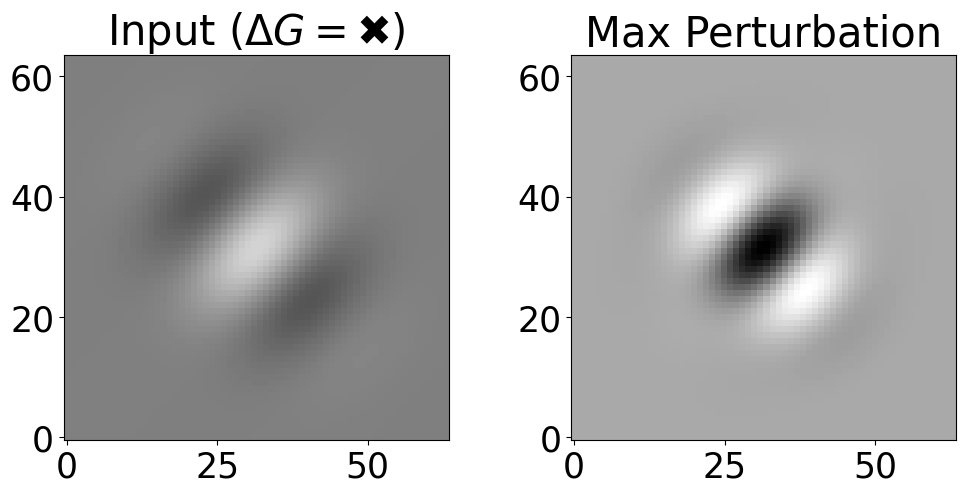

In [404]:
plt.rcParams.update({'font.size': 25})
n_rows = 1
beta = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 5 * n_rows))
gabor_range = np.max(np.abs(np.asarray(gabor)))
img = axes[0].imshow(np.asarray(gabor).reshape(64, 64),vmin=-0.753,vmax=0.753, cmap='grey')
# fig.colorbar(img, ax=axes[0])
axes[0].set_title(r"Input ($\Delta G=$"'✖)')
axes[0].invert_yaxis()

img = axes[1].imshow(np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[1])
axes[1].set_title(f"Max Perturbation")
axes[1].invert_yaxis()


# axes[2].plot(np.asarray(response), label='r_E')
# axes[2].plot(np.asarray(ring.r_I), label='r_I')
# axes[2].set_title(f"Response on Ring")
# response_new = ring.forward(torch.from_numpy(gabor.reshape(-1))+beta*(V[0, :]))
# axes[2].plot(np.asarray(response_new), label='delta_r_E')
# axes[2].plot(np.asarray(ring.r_I), label='delta_r_I')
# axes[2].legend()

# img = axes[3].imshow(np.asarray(gabor).reshape(64, 64)+beta*np.asarray(V[0, :]).reshape(64, 64),vmin=0,vmax=1, cmap='grey')
# fig.colorbar(img, ax=axes[3])
# axes[3].set_title(f"Gabor Input \n with Max Perturbation")


In [ ]:
plt.rcParams.update({'font.size': 14})
n_rows = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(18, 5 * n_rows))

gabor_range = np.max(np.abs(np.asarray(gabor)))
img = axes[0, 0].imshow(np.asarray(gabor).reshape(64, 64), vmin=-gabor_range, vmax=gabor_range, cmap='grey')
fig.colorbar(img, ax=axes[0, 0])
axes[0, 0].set_title(f"Gabor Input")
axes[0, 0].invert_yaxis()

# img = axes[1, 0].imshow(np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[1, 0])
# axes[1, 0].set_title(f"Gain = {S[0]:.2f}")

# img = axes[1, 1].imshow(np.asarray(V[1, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[1, 1])
# axes[1, 1].set_title(f"Gain = {S[1]:.2f}")

# mg = axes[1, 2].imshow(np.asarray(V[2, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[1, 2])
# axes[1, 2].set_title(f"Gain = {S[2]:.2f}")

# For the first image
data0 = np.asarray(V[0, :]).reshape(64, 64)
abs_max0 = np.max(np.abs(data0))  # Calculate the maximum absolute value
img0 = axes[1, 0].imshow(data0, cmap='grey', vmin=-abs_max0, vmax=abs_max0)  # Set vmin and vmax
fig.colorbar(img0, ax=axes[1, 0])  # Add color bar
axes[1, 0].set_title(f"Gain = {S[0]:.2f}")  # Set title
axes[1, 0].invert_yaxis()

# For the second image
data1 = np.asarray(V[1, :]).reshape(64, 64)
abs_max1 = np.max(np.abs(data1))  # Calculate the maximum absolute value
img1 = axes[1, 1].imshow(data1, cmap='grey', vmin=-abs_max1, vmax=abs_max1)  # Set vmin and vmax
fig.colorbar(img1, ax=axes[1, 1])  # Add color bar
axes[1, 1].set_title(f"Gain = {S[1]:.2f}")  # Set title
axes[1, 1].invert_yaxis()

# For the third image
data2 = np.asarray(V[2, :]).reshape(64, 64)
abs_max2 = np.max(np.abs(data2))  # Calculate the maximum absolute value
img2 = axes[1, 2].imshow(data2, cmap='grey', vmin=-abs_max2, vmax=abs_max2)  # Set vmin and vmax
fig.colorbar(img2, ax=axes[1, 2])  # Add color bar
axes[1, 2].set_title(f"Gain = {S[2]:.2f}")  # Set title
axes[1, 2].invert_yaxis()

perturbated_gabor = np.asarray(gabor).reshape(64, 64) + 1 * np.asarray(V[0, :]).reshape(64, 64)
gabor_range_perturbation = np.max(np.abs(np.asarray(perturbated_gabor)))
img = axes[0, 1].imshow(perturbated_gabor, vmin=-gabor_range_perturbation, vmax=gabor_range_perturbation, cmap='grey')
fig.colorbar(img, ax=axes[0, 1])
axes[0, 1].set_title(f"Gabor Input \n with Max Perturbation")
axes[0, 1].invert_yaxis()

response_I = ring.r_I
axes[0, 2].plot(np.asarray(response), label=r'$r_E$')
axes[0, 2].plot(np.asarray(response_I), label=r'$r_I$')
axes[0, 2].set_title(f"Response on Ring")
response_new = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[0, :]))
axes[0, 2].plot(np.asarray(response_new), label=r'$r_E^{\prime}$')
axes[0, 2].plot(np.asarray(ring.r_I), label=r'$r_I^{\prime}$')
axes[0, 2].legend()
axes[0, 2].set_xlabel(r'$\theta$')
axes[0, 2].set_ylabel('firing rates(Hz)')

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Response of Perturbaion on Ring')

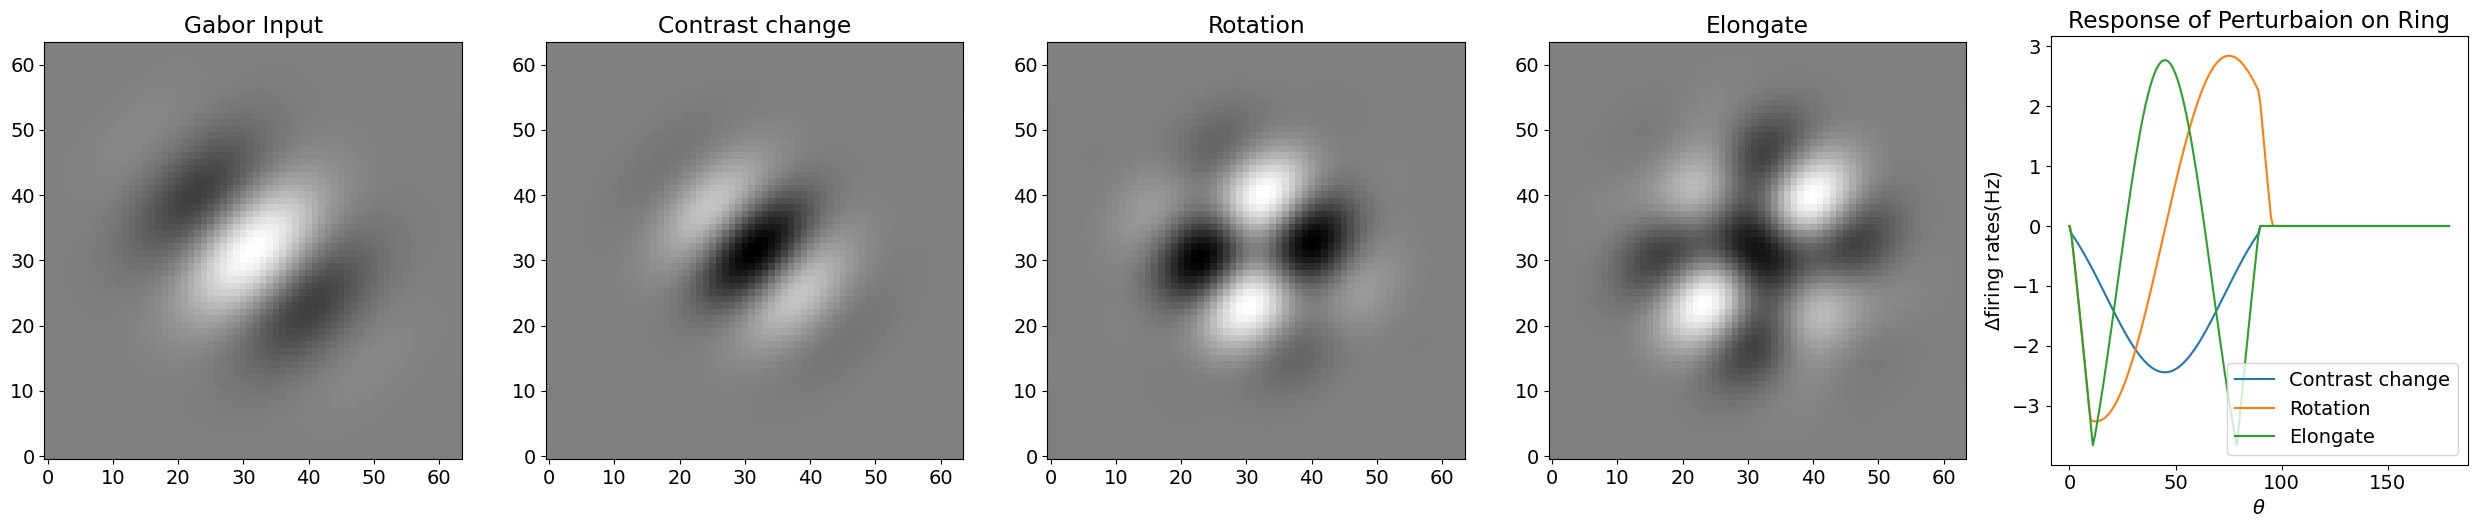

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

gabor_range = np.max(np.abs(np.asarray(gabor)))
img = axes[0].imshow(np.asarray(gabor).reshape(64, 64), vmin=-gabor_range, vmax=gabor_range, cmap='grey')
# fig.colorbar(img, ax=axes[0])
axes[0].set_title(f"Gabor Input")
axes[0].invert_yaxis()

# For the first image
data0 = np.asarray(V[2, :]).reshape(64, 64)
abs_max0 = np.max(np.abs(data0))  # Calculate the maximum absolute value
img0 = axes[1].imshow(data0, cmap='grey', vmin=-abs_max0, vmax=abs_max0)  # Set vmin and vmax
# fig.colorbar(img0, ax=axes[1])  # Add color bar
axes[1].set_title(f"Contrast change")  # Set title
axes[1].invert_yaxis()

# For the second image
data1 = np.asarray(V[1, :]).reshape(64, 64)
abs_max1 = np.max(np.abs(data1))  # Calculate the maximum absolute value
img1 = axes[2].imshow(data1, cmap='grey', vmin=-abs_max1, vmax=abs_max1)  # Set vmin and vmax
# fig.colorbar(img1, ax=axes[1])  # Add color bar
# axes[1].set_title(f"Gain = {S[1]}")  # Set title
axes[2].set_title(f"Rotation")
axes[2].invert_yaxis()

# For the third image
data2 = np.asarray(V[0, :]).reshape(64, 64)
abs_max2 = np.max(np.abs(data2))  # Calculate the maximum absolute value
img2 = axes[3].imshow(data2, cmap='grey', vmin=-abs_max2, vmax=abs_max2)  # Set vmin and vmax
# fig.colorbar(img2, ax=axes[2])  # Add color bar
# axes[2].set_title(f"Gain = {S[0]}")  # Set title
axes[3].set_title(f"Elongate")
axes[3].invert_yaxis()

ax1 = axes[4]  # Original axis
# ax2 = ax1.twinx()  # Create a second y-axis

# First y-axis (Excitatory response)
# ax1.plot(np.asarray(response), label='r_E')
# # ax1.plot(np.asarray(ring.r_I), label='r_I')
# ax1.set_ylabel('Origin Response')
# ax1.tick_params(axis='y')
# ax1.set_title(f"Response on Ring")

response_new1 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[0, :])) - response.reshape(-1)
response_new2 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[1, :])) - response.reshape(-1)
response_new3 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[2, :])) - response.reshape(-1)

# Second y-axis (Inhibitory response)
ax1.plot(np.asarray(response_new3), label='Contrast change')
ax1.plot(np.asarray(response_new2), label='Rotation')
ax1.plot(np.asarray(response_new1), label='Elongate')
# ax2.plot(np.asarray(ring.r_I), label='delta_r_I', color='orange')
ax1.set_ylabel('Perturbation Response')
ax1.tick_params(axis='y')

# Add legend
ax1.legend()
# ax2.legend(loc='upper right')

box = axes[4].get_position()  # Get the initial position of the subplot
axes[4].set_position([box.x0, box.y0, box.width, box.height])
plt.tight_layout()
axes[4].set_xlabel(r'$\theta$')
axes[4].set_ylabel(r'$\Delta$firing rates(Hz)')
axes[4].set_title(f"Response of Perturbation on Ring")

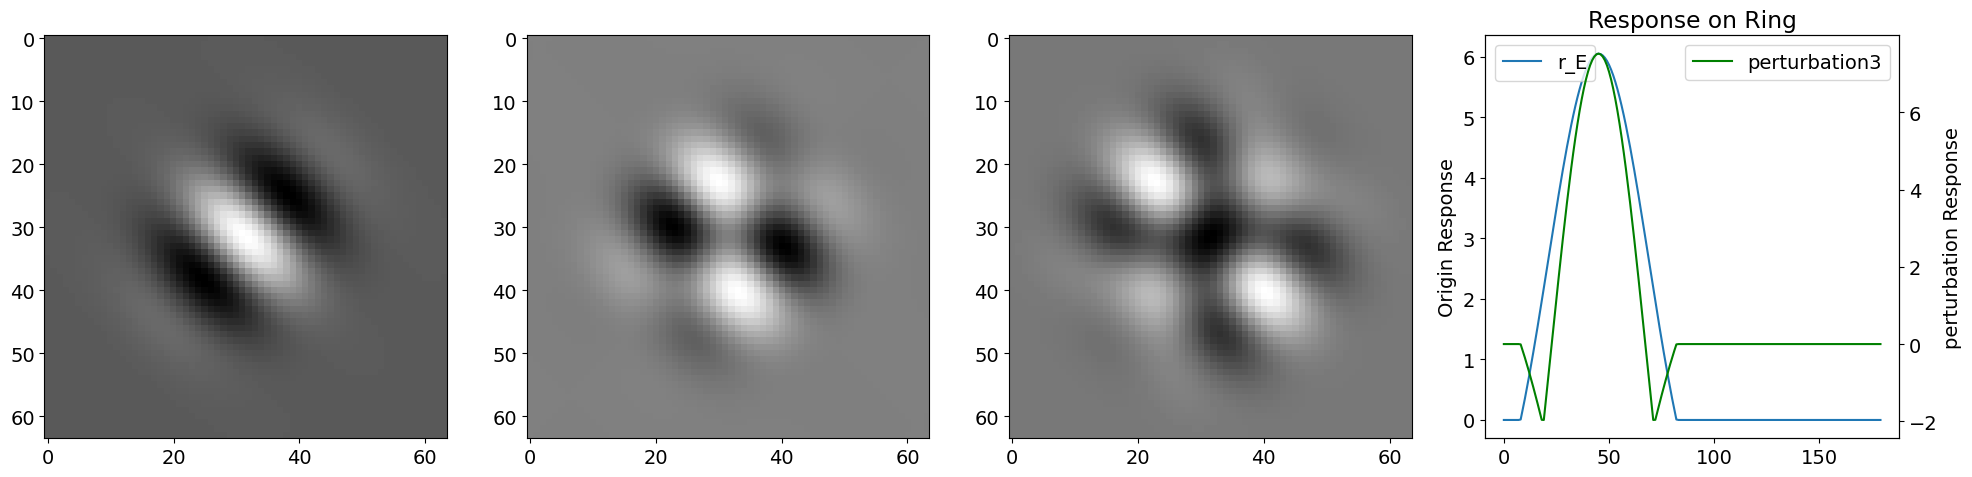

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
img = axes[0].imshow(np.asarray(V[2, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[0])
# axes[0].set_title(f"Gain = {S[0]}")

img = axes[1].imshow(np.asarray(V[1, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[1])
# axes[1].set_title(f"Gain = {S[1]}")

mg = axes[2].imshow(np.asarray(V[0, :]).reshape(64, 64), cmap='grey')
# fig.colorbar(img, ax=axes[2])
# axes[2].set_title(f"Gain = {S[2]}")

ax1 = axes[3]  # Original axis
ax2 = ax1.twinx()  # Create a second y-axis

# First y-axis (Excitatory response)
ax1.plot(np.asarray(response), label='r_E')
# ax1.plot(np.asarray(ring.r_I), label='r_I')
ax1.set_ylabel('Origin Response')
ax1.tick_params(axis='y')
ax1.set_title(f"Response on Ring")

# response_new1 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[0, :])) - response.reshape(-1)
# response_new2 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[1, :])) - response.reshape(-1)
response_new3 = ring.forward(torch.from_numpy(gabor.reshape(-1)) + beta * (V[2, :])) - response.reshape(-1)

# Second y-axis (Inhibitory response)
# ax2.plot(np.asarray(response_new1), label='perturbation1', color='red')
# ax2.plot(np.asarray(response_new2), label='perturbation2', color='grey')
ax2.plot(np.asarray(response_new3), label='perturbation3', color='green')
# ax2.plot(np.asarray(ring.r_I), label='delta_r_I', color='orange')
ax2.set_ylabel('Perturbation Response')
ax2.tick_params(axis='y')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

box = axes[3].get_position()  # Get the initial position of the subplot
axes[3].set_position([box.x0, box.y0, box.width, box.height])
plt.tight_layout()